<a href="https://colab.research.google.com/github/phaa/dio-baires-dev/blob/main/dio_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Pest detection in cotton crops

### Objectives

This project aims to use convolutional neural networks (CNNs) to detect different pests in cotton crops.

* Analyze the distribution of instances in the dataset (training and validation).
* Pre-process and divide the dataset correctly.
* Apply normalization to the images.
* Apply data augmentation to expand the training and avoid overfitting.
* Use transfer learning to extract features in a more robust way.
* Test and validate the model.

### Author

<a href='https://www.linkedin.com/in/pedro-henrique-amorim-de-azevedo/' target='_blank'>Pedro Henrique Amorim de Azevedo</a>

# Let's start by import the necessary libraries

In [ ]:
!pip install -q numpy 
!pip install -q scipy
!pip install -q pandas
!pip install -q seaborn
!pip install -q matplotlib
!pip install -q tensorflow[and-cuda]
!pip install -q pillow 
!pip install -q scikit-learn

In [176]:
%matplotlib inline

import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image

# Vamos importar o Kera do próprio tensorflow
from tensorflow import keras
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAvgPool2D
from keras.models import Model, load_model
from keras.optimizers import AdamW

from sklearn.metrics import classification_report, confusion_matrix

We need to check our Tensorflow ecossystem and the GPU status as well.

In [2]:
print(tf.__version__)

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2.19.0
1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1744639145.717572   11875 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7793 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


## Dataset Description 

This dataset contains images of two pest species that significantly compromise cotton crops in Brazil: 

<div style="display: flex; justify-content: center;">
  <table style="border-collapse: collapse; width: 60%; text-align: center; font-size: 16px;">
    <tr style="background-color: #f2f2f2;">
      <th style="border: 1px solid #ddd; padding: 10px;">Species</th>
      <th style="border: 1px solid #ddd; padding: 10px;">Description</th>
    </tr>
    <tr>
      <td style="border: 1px solid #ddd; padding: 10px;">Weevil</td>
      <td style="border: 1px solid #ddd; padding: 10px;">Insect with fine jaws that pierce the flower buds and bolls of
        cotton plants (Anthonomus grandis)</td>
    </tr>
    <tr style="background-color: #f9f9f9;">
      <td style="border: 1px solid #ddd; padding: 10px;">Whitefly</td>
      <td style="border: 1px solid #ddd; padding: 10px;">A sucking insect that steals nutrients from the plant it is on
        (*Bemisia tabaci*)</td>
    </tr>
  </table>
</div>

In [3]:
DATASET_PATH = 'datasets/'
CLASSES = os.listdir(DATASET_PATH)
IMAGEM_SIZE = (224, 224)
LEARNING_RATE = 10e-3
WEIGHT_DECAY = 10e-4
MODEL_PATH = 'models/best_model.keras'

print(f'Dataset instance classes: {CLASSES}')

Dataset instance classes: ['whitefly', 'weevil']


### Checking class distribution

For training to be as effective as possible, we need to make sure that the dataset is well distributed among the classes. Otherwise, our model may be biased.

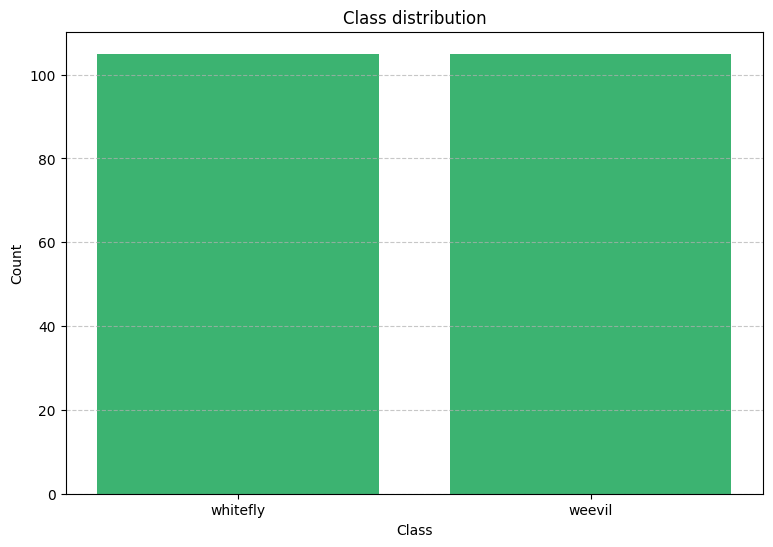

In [4]:
distribution = {}
for class_name in CLASSES:
	_, _, files = next(os.walk(os.path.join(DATASET_PATH, class_name)))
	distribution[class_name] = len(files)

plt.figure(figsize=(9, 6))
plt.bar(distribution.keys(), distribution.values(), color='mediumseagreen')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class distribution')
plt.xticks()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

As we can see, our dataset is well balanced.

# Dataset samples

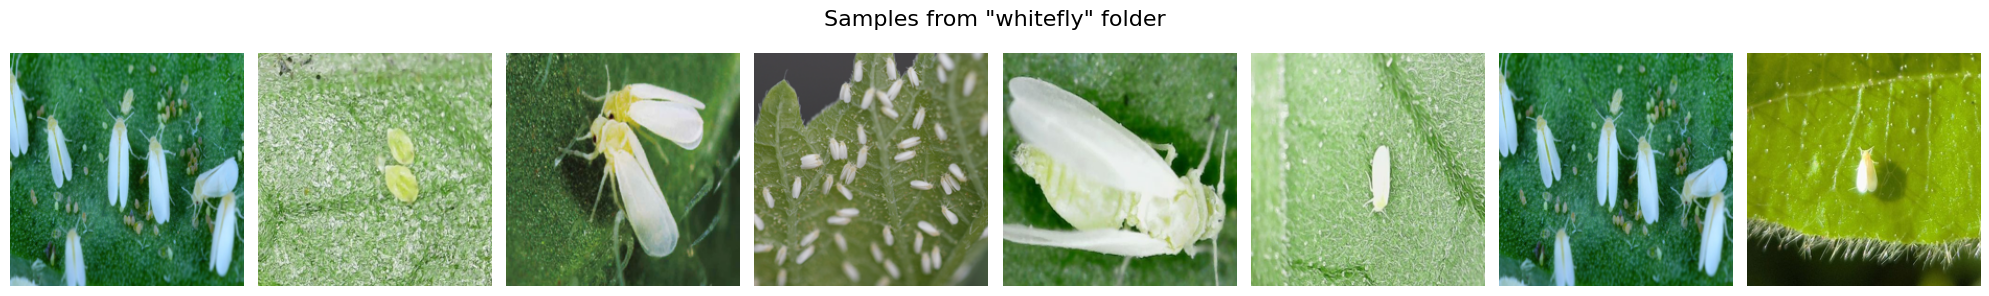

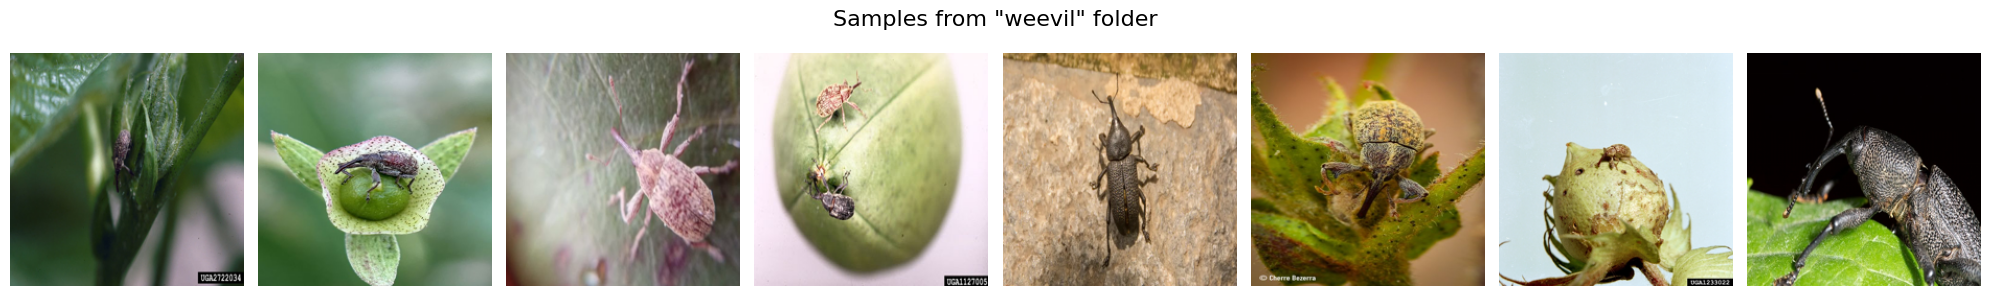

In [5]:
def plot_dataset_samples(data_class: str, num_images=8):
    selected_images = []	
    class_path = os.path.join(DATASET_PATH, data_class)
    
    for _ in range(num_images):
        selected_path = random.choice(os.listdir(class_path))
        image_path = os.path.join(class_path, selected_path)
        selected_images.append(image_path)

    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))

    for i, image_path in enumerate(selected_images):
        img = Image.open(image_path)
        img = img.resize(IMAGEM_SIZE)
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.suptitle(f'Samples from "{data_class}" folder', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 1.25])
    plt.show();


for class_name in CLASSES:
    plot_dataset_samples(class_name)


### Helper function to transform some image to an array

In [6]:
def get_image(path):
    img = image.load_img(path, target_size=IMAGEM_SIZE)
    img_arr = image.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    img_arr = img_arr / 255
    return img, img_arr

In [7]:
CLASSES

['whitefly', 'weevil']

# Loading dataset

In [8]:
data = []
for cat_index, category in enumerate(CLASSES):
    images = []
    category_path = os.path.join(DATASET_PATH, category)
    for file in os.listdir(category_path):
        img, img_arr = get_image(os.path.join(category_path, file))
        data.append({'x': np.array(img_arr[0]), 'y': cat_index})

/home/pedro/anaconda3/envs/intellisis/lib/python3.9/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### We must ensure to shuffle all the data

In [9]:
random.shuffle(data)

# Train, validation and test splits

In [10]:
train_split, val_split = 0.7, 0.15
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))

train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

### Separate the features from the labels

In [11]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1]


# Converting labels to one-hot encoding

In [12]:
num_classes = len(CLASSES)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(32, 2)


In [13]:
print('Finished loading {0} images from {1} categories'.format(len(data), num_classes))
print('Training: {0} | Validation {1} | Test {2}'.format(len(x_train), len(x_val), len(x_test)))
print("Training set shape", x_train.shape)
print("Training set shape", y_train.shape)

Finished loading 210 images from 2 categories
Training: 147 | Validation 31 | Test 32
Training set shape (147, 224, 224, 3)
Training set shape (147, 2)


# Building the prototype neural network
Before building a transfer learning network, let's create one from scratch.
This way, we can compare the performance of a completely new network with a more mature one.

In [149]:
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAvgPool2D())
model.add(Flatten())

model.add(Dense(512, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dense(256, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

#model.summary()

/home/pedro/anaconda3/envs/intellisis/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


We will train our model for 40 epochs, using the categorical cross-entropy loss and the Adaptive Moment Estimation optimizer for gradient descent.

In [150]:
callbacks = [
    ModelCheckpoint(
        MODEL_PATH, monitor="val_accuracy", save_best_only=True, mode="max"
    ),
    ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1
    ),
]

optimizer = AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=100,
    callbacks=callbacks,
    validation_data=(x_val, y_val),
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5923 - loss: 1.2551 - val_accuracy: 0.4194 - val_loss: 379.3199 - learning_rate: 0.0100
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.6797 - loss: 0.9313 - val_accuracy: 0.4194 - val_loss: 2722.7273 - learning_rate: 0.0100
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.7091 - loss: 0.7370 - val_accuracy: 0.4194 - val_loss: 4136.9043 - learning_rate: 0.0100
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.8358 - loss: 0.5252 - val_accuracy: 0.4194 - val_loss: 1874.1516 - learning_rate: 0.0100
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.7574 - loss: 0.5216 - val_accuracy: 0.4194 - val_loss: 733.7014 - learning_rate: 0.0100
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.8876 - loss: 0.3056 - val_accuracy: 0.4194 - val_loss: 260.9015 - learning_rate: 0.0100
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.8439 - loss: 0.3

# Training history

In [154]:
def plot_training_history(train_history):
    fig = plt.figure(figsize=(16,5))

    # Accuracy history
    ax = fig.add_subplot(121)
    ax.plot(train_history['accuracy'])
    ax.plot(train_history['val_accuracy'])
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Validation'], loc='upper left')

    # Loss history
    ax2 = fig.add_subplot(122)
    ax2.plot(train_history['loss'])
    ax2.plot(train_history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    plt.show();


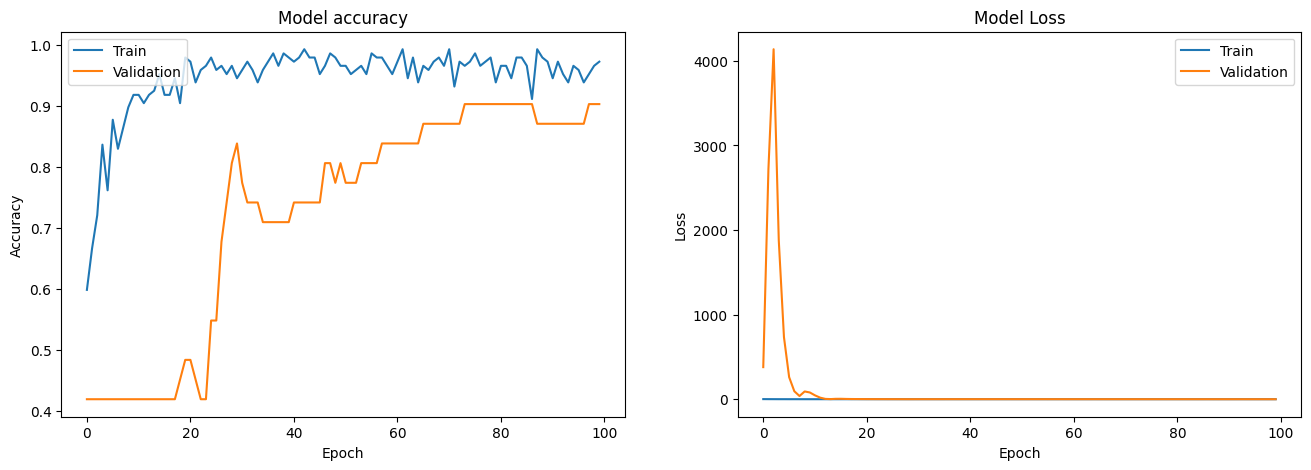

In [155]:
plot_training_history(history.history)

# Evaluating the model made from scratch

Through the accuracy graph, we can see that, in the test set, the performance of our network is lower, which indicates that the model may be overfitting to the test set.
On the loss graph, this situation seems to get much worse as the model progresses in training. This is because the model fits very well to the test set, but does not become good enough for new examples.

In [156]:
best_model = load_model(MODEL_PATH)

In [ ]:
loss, accuracy = best_model.evaluate(x_test, y_test, verbose=0)
print('Loss in test set:', loss)
print('Accuracy in test set:', accuracy)

Loss in test set: 0.3020176887512207
Accuracy in test set: 0.84375


In [178]:
def plot_conf_matrix_report(y_pred, y_test):
	plt.figure(figsize=(22, 8))

	# Subplot 1 - Classification Report
	plt.subplot(1, 2, 1)
	plt.title('Classification Report')
	clf_report = classification_report(y_test, y_pred, output_dict=True)
	report_df = pd.DataFrame(clf_report).iloc[:-1, :].T  # Remove 'support'
	sns.heatmap(report_df, annot=True, cmap='coolwarm', fmt='.2f')

	# Subplot 2 - Confusion Matrix
	plt.subplot(1, 2, 2)
	plt.title('Confusion Matrix')
	conf_matrix = confusion_matrix(y_test, y_pred)
	sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
	
	plt.tight_layout()
	plt.show()


## Classification report & Confusion matrix

Let's do some predictions on test set and plot the confusion report alongside the confusion matrix

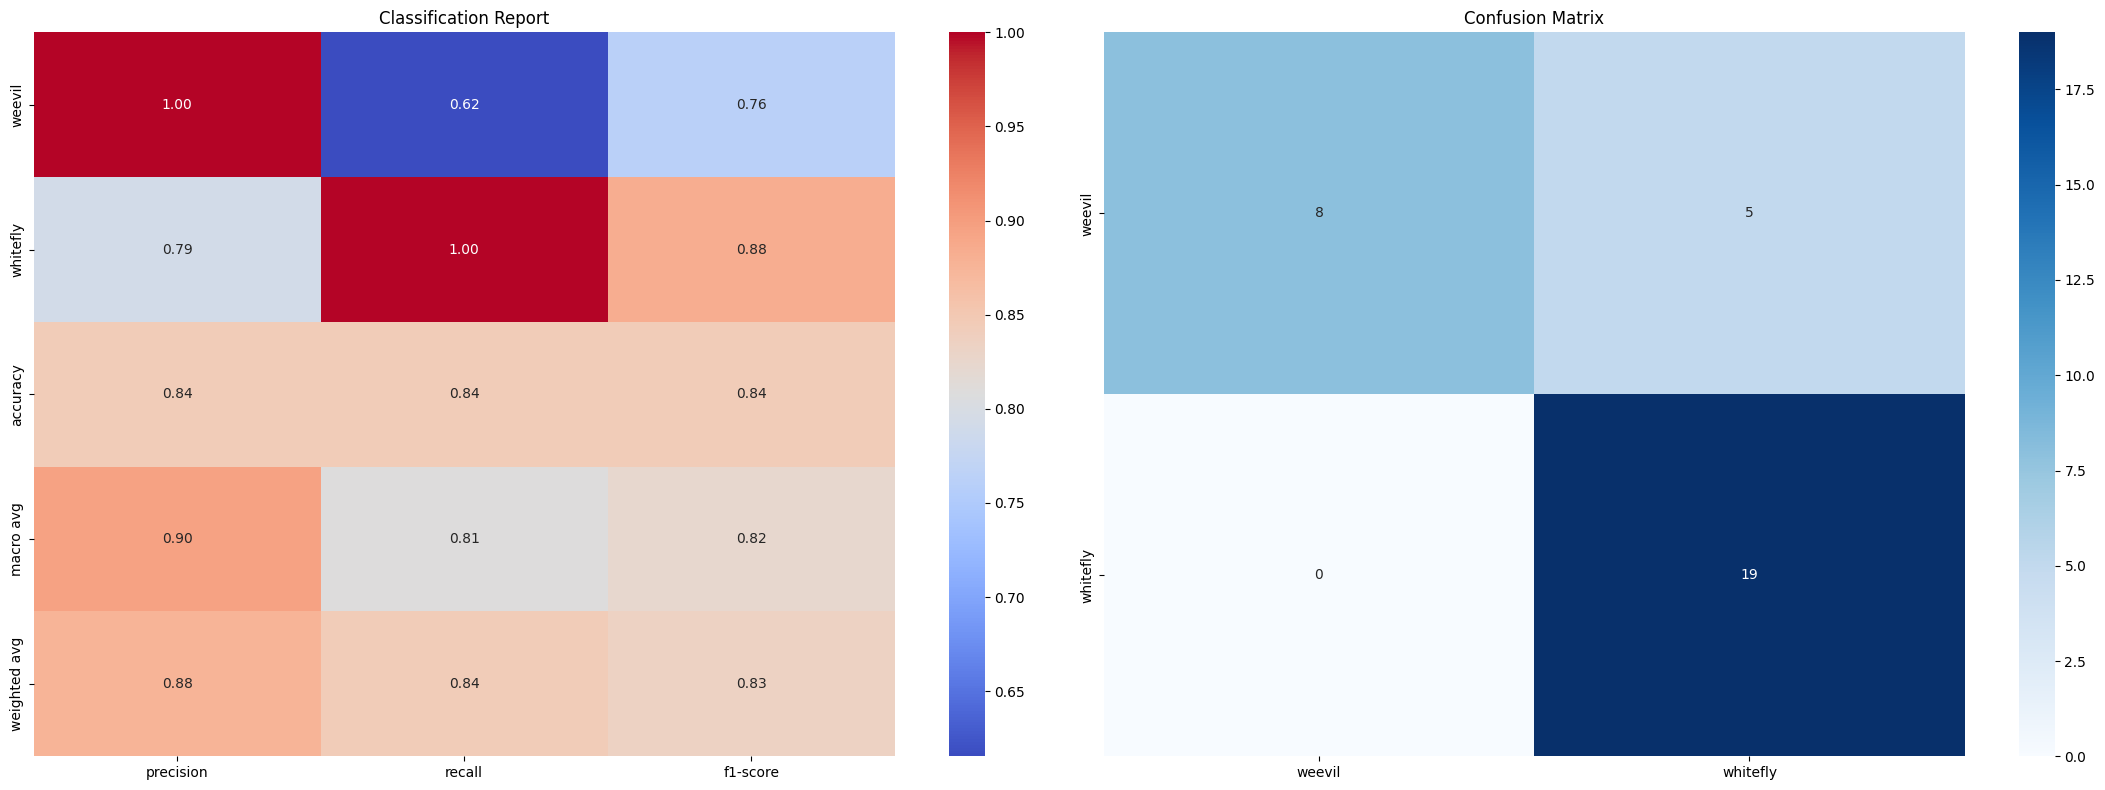

In [179]:
y_pred = best_model.predict(x_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

get_class_names = np.vectorize(lambda c: CLASSES[c])

y_pred_classes = get_class_names(y_pred_classes)
y_true_classes = get_class_names(y_true_classes)

plot_conf_matrix_report(y_pred_classes, y_true_classes)

## Testing a sample image

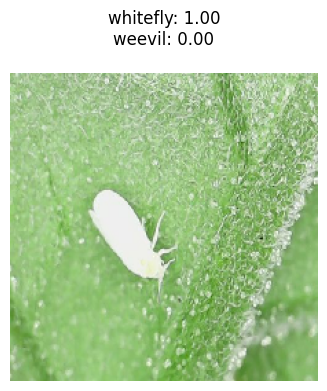

In [161]:
img, x = get_image(os.path.join(DATASET_PATH, 'whitefly/MoscaBranca04.png'))
probabilities = best_model.predict(x, verbose=0)[0]

title = ''
for i in range(probabilities.size):
    title += '{0}: {1:.2f}\n'.format(CLASSES[i], probabilities[i])

plt.figure(figsize=(20,4))
plt.axis('off')
plt.title(title)
plt.imshow(img);

# Using transfer learning
### Now we will use a pre-trained neural network to classify our own classes.
We will use a Keras VGG network that was trained with the ImageNet dataset and had its weights saved online.

In [162]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
out = Dense(num_classes, activation="softmax")(vgg.layers[-2].output)

model_new = Model(vgg.input, out)

for layer in vgg.layers[:-1]:
    layer.trainable = False

model_new.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

model_new.summary()

Model: "functional_720"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [165]:
# Agora treinamos a nova rede
history2 = model_new.fit(
    x_train, y_train, batch_size=64, epochs=40, validation_data=(x_val, y_val)
)

Epoch 1/40


2025-04-14 12:27:47.246156: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_596', 8 bytes spill stores, 8 bytes spill loads

2025-04-14 12:27:47.684820: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_603', 4 bytes spill stores, 4 bytes spill loads

2025-04-14 12:27:47.893997: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_596', 488 bytes spill stores, 488 bytes spill loads

2025-04-14 12:27:48.167273: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_596', 820 bytes spill stores, 820 bytes spill loads

2025-04-14 12:27:48.230945: I external/local

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.6211 - loss: 0.9521

2025-04-14 12:28:06.337171: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_596', 4 bytes spill stores, 4 bytes spill loads

2025-04-14 12:28:06.519755: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_596_0', 36 bytes spill stores, 36 bytes spill loads

2025-04-14 12:28:06.875872: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_596', 532 bytes spill stores, 532 bytes spill loads

2025-04-14 12:28:06.990070: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_596', 476 bytes spill stores, 476 bytes spill loads

2025-04-14 12:28:07.046289: I external/l

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6113 - loss: 1.0113   

2025-04-14 12:28:16.673669: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_222_0', 36 bytes spill stores, 36 bytes spill loads

2025-04-14 12:28:17.242306: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_222', 3432 bytes spill stores, 3164 bytes spill loads

2025-04-14 12:28:17.386861: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_222', 532 bytes spill stores, 532 bytes spill loads

2025-04-14 12:28:17.402447: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_222', 476 bytes spill stores, 476 bytes spill loads

2025-04-14 12:28:17.466812: I exte

3/3 ━━━━━━━━━━━━━━━━━━━━ 43s 12s/step - accuracy: 0.6065 - loss: 1.0409 - val_accuracy: 0.6452 - val_loss: 0.5808
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.6050 - loss: 0.6300 - val_accuracy: 0.9355 - val_loss: 0.5177
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.7624 - loss: 0.5231 - val_accuracy: 0.6774 - val_loss: 0.5512
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.8173 - loss: 0.4358 - val_accuracy: 0.7419 - val_loss: 0.4209
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.7891 - loss: 0.4544 - val_accuracy: 0.9355 - val_loss: 0.3660
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.8646 - loss: 0.3790 - val_accuracy: 0.7742 - val_loss: 0.4747
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.7983 - loss: 0.3843 - val_accuracy: 0.9677 - val_loss: 0.2931
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.8559 - loss: 0.3579 - val_accuracy: 0.9355 - val_loss: 0.2922
Epoc

# Plotando o resultado final

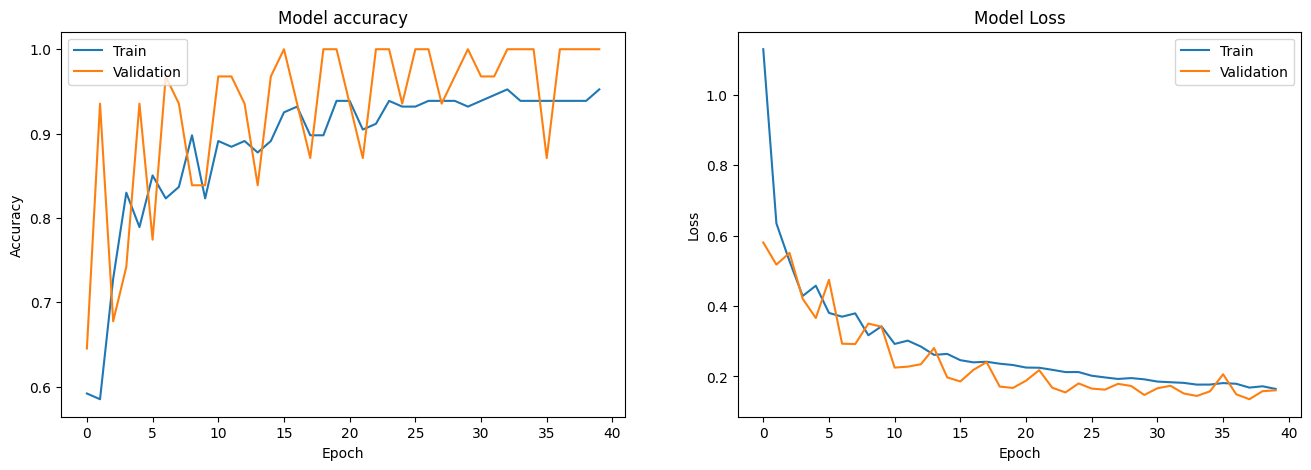

In [168]:
plot_training_history(history2.history)

Through the graphs, we can see that the accuracy metrics of the test set are very close to the training set, i.e. the model is converging. This indicates that there was no overfitting in the model. 
# Evaluating the metrics of the new model

In [169]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)
print('Loss in test set:', loss)
print('Accuracy in test set:', accuracy)

Loss in test set: 0.19170987606048584
Accuracy in test set: 0.90625


## Classification report & confusion matrix

Let's plot the results obtained with the new model on the test set

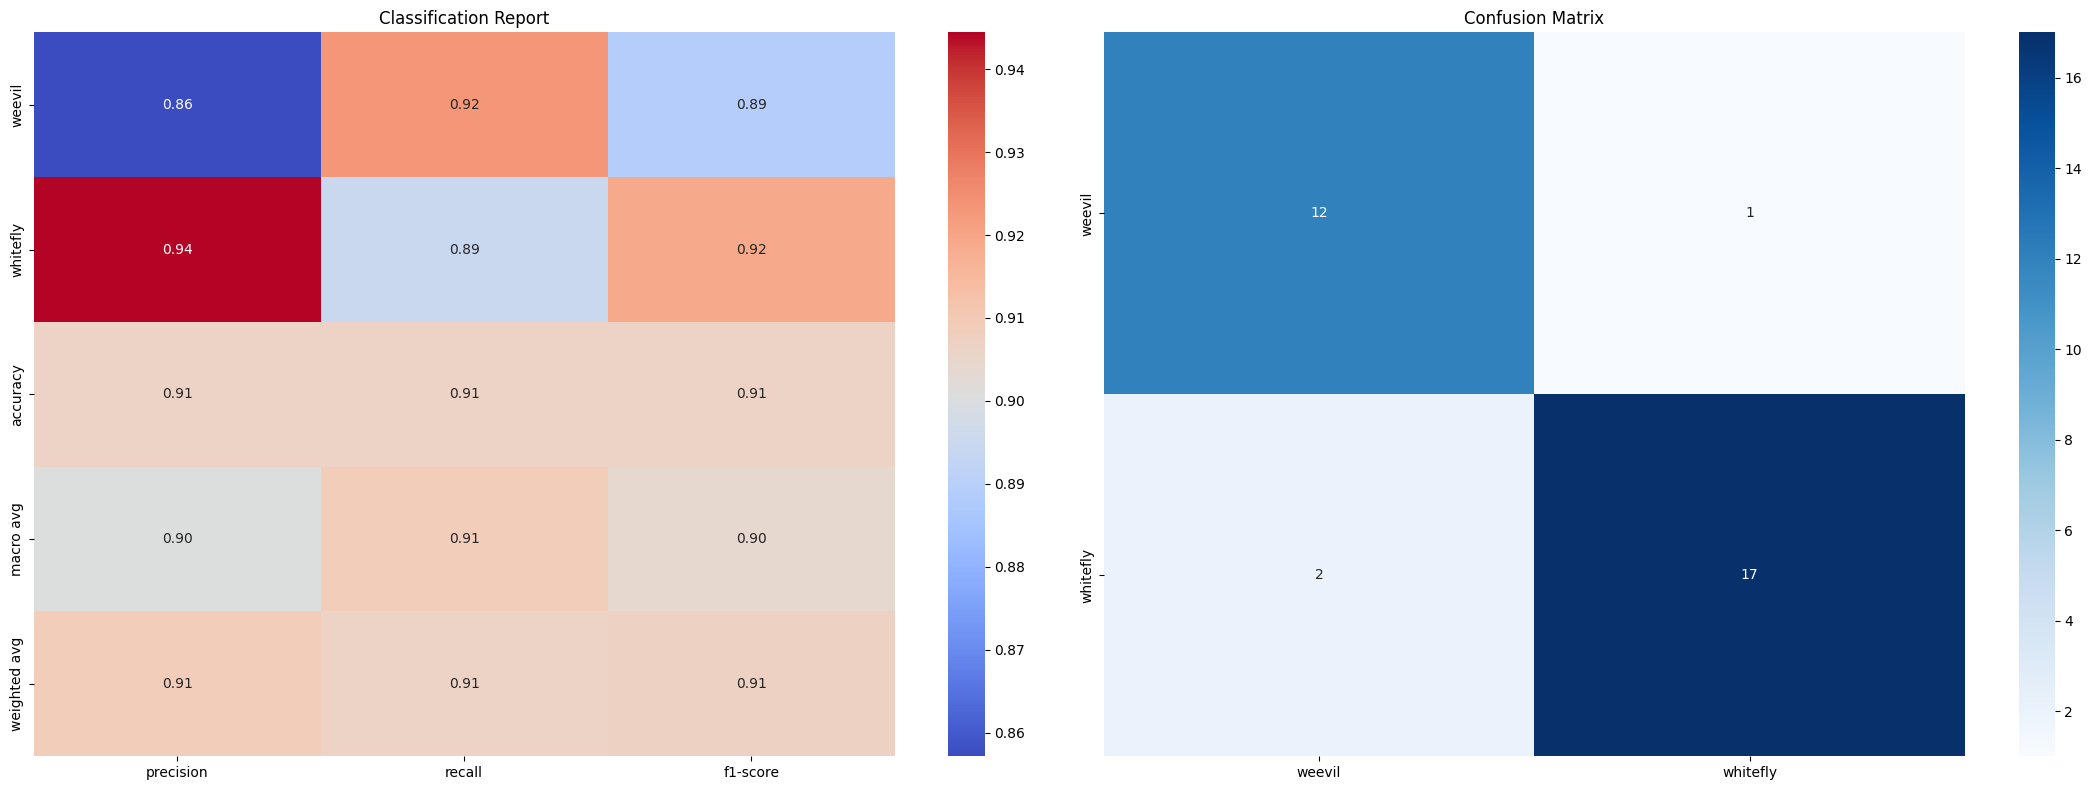

In [181]:
y_pred = model_new.predict(x_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

get_class_names = np.vectorize(lambda c: CLASSES[c])

y_pred_classes = get_class_names(y_pred_classes)
y_true_classes = get_class_names(y_true_classes)

plot_conf_matrix_report(y_pred_classes, y_true_classes)

## Testing a sample image

2025-04-14 13:26:23.006001: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 184 bytes spill stores, 184 bytes spill loads

2025-04-14 13:26:24.020163: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 4896 bytes spill stores, 4888 bytes spill loads

2025-04-14 13:26:24.106477: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 4244 bytes spill stores, 4236 bytes spill loads



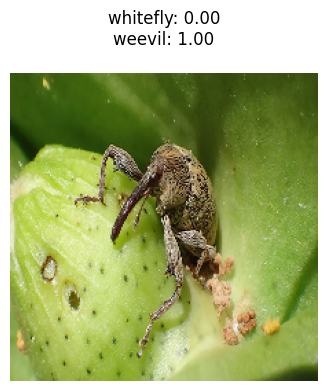

In [180]:
img, x = get_image(os.path.join(DATASET_PATH, 'weevil/bicudo07.png'))
probabilities = model_new.predict(x, verbose=0)[0]

title = ''
for i in range(probabilities.size):
    title += '{0}: {1:.2f}\n'.format(CLASSES[i], probabilities[i])

plt.figure(figsize=(20,4))
plt.axis('off')
plt.title(title)
plt.imshow(img);